In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('dataset.csv')

In [3]:
data['AveragePosition'] = data['Average.Position']
data.drop('Average.Position', axis=1, inplace=True)

# Data cleaning and exploration

We remove the rows with any null values

In [4]:
data.dropna(inplace=True)

This removes 3514 rows, which is only 0.98% of the original dataset

Next we have to convert the CTR values from string to float values

In [5]:
data.CTR = data.CTR.apply(lambda x: x[:-1]).astype('float64')

In [6]:
data.head()

,Date,Market,Keyword,CPC,Clicks,CTR,Impressions,Cost,AveragePosition
0,20120524,US-Market,secure online back up,0.0,0.00,0.0,0.0,0.00,0.0
1,20120524,US-Market,agile management software,1.2,21.22,8.2,260.0,25.45,1.0
2,20120524,US-Market,crm for financial,0.0,0.00,0.0,0.0,0.00,0.0
3,20120524,US-Market,disaster recovery planning for it,0.0,0.00,0.0,0.0,0.00,0.0
4,20120524,US-Market,tracking a vehicle,0.0,0.00,0.0,0.0,0.00,0.0


In [7]:
data.describe()

,Date,CPC,Clicks,CTR,Impressions,Cost,AveragePosition
count,3.525400e+05,352540.000000,352540.000000,352540.000000,3.525400e+05,352540.000000,352540.000000
mean,2.012271e+07,14.287964,220.299838,1.630900,9.758862e+03,1900.441204,0.611163
std,3.589467e+03,37.882436,1719.222177,2.033744,7.145521e+04,10060.075649,0.644052
min,2.012052e+07,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,2.012090e+07,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,2.012102e+07,1.080000,2.090000,0.800000,1.270000e+02,7.930000,1.000000
75%,2.012122e+07,12.070000,34.870000,2.800000,1.553000e+03,369.810000,1.000000
max,2.013021e+07,632.730000,89233.580000,23.700000,3.666042e+06,285716.050000,12.000000


Notice that there are a lot of zeroes in the dataset. For the six numeric features (CPC, CTR, clicks, impressions, cost and average position), **the 25th percentile is zero**. In addition, **the CPC, CTR, clicks, impressions and cost features are heavily skewed to the right** as easily determined by comparing their 75th percetile to their mean values. We might need to eliminate a lot of rows in the dataset to have meaningful predictions. In addition, taking the logarithm of Clicks and Impressions will improve their suitability for machine learning models.

We have to investigate further into the frequency of zeroes in the dataset:

In [8]:
zeroCPCrows = data[data.CPC == 0.0]
zeroCPCrows.shape[0]

148945

In [9]:
zeroCPCrows.Clicks.sum(), zeroCPCrows.CTR.sum(), zeroCPCrows.Cost.sum()

(0.0, 0.0, 0.0)

We see that there are 148,945 rows with zero CPC. Also, **a zero CPC immediately implies zero Clicks, CTR and cost** in the dataset.

In [10]:
subset_zeroCPCrows = zeroCPCrows[(zeroCPCrows.Impressions != 0) | (zeroCPCrows.AveragePosition != 0)]
subset_zeroCPCrows.shape[0]

48

There are 48 rows with zero CPC but nonzero Impressions or Average Position. Let's filter them out and call the resulting dataframe `fullyzeroCPCrows`

In [11]:
fullyzeroCPCrows = zeroCPCrows[(zeroCPCrows.Impressions == 0) & (zeroCPCrows.AveragePosition == 0)]
fullyzeroCPCrows.shape[0], fullyzeroCPCrows.Keyword.nunique() 

(148897, 837)

There are 148,897 rows with zero CPC, CTR, Clicks, Cost, Impressions and Average Position. **This is 42% of the whole dataset!** But before we make any decisions, let's review some definitions first.

According to Google Ads:
- CTR is the total number of clicks that your ad receives divided by the total number of times your ad is shown. A high CPC shows that users find your ads useful and relevant. [Source.](https://support.google.com/google-ads/answer/2615875?hl=en) $$ \textbf{CTR} = \frac{\textbf{total clicks}}{\textbf{total impressions}}$$
- CPC is the average amount that you've been charged for a click on your ad. [Source.](https://support.google.com/google-ads/answer/14074?hl=en&ref_topic=24937) $$ \textbf{CPC} = \frac{\textbf{total cost}}{\textbf{total clicks}}$$
- Ad position is the order in which your ad appears on a page in relation to other ads. For example, an ad position of "1" means that your ad has the highest position on the page relative to other ads of the same type. [Source.](https://support.google.com/google-ads/answer/6300?hl=en&ref_topic=24937) The 'Position 0' is commonly used to refer to ads that land as the featured snippet in a google search query. ([Source1](https://www.searchenginejournal.com/content-types-position-zero/232453/#close), [Source2](https://www.searchenginejournal.com/content-types-position-zero/232453/#close)) However Google only introduced featured snippets in 2014, but our dataset contains data from 2012-2013

There are multiple possible interpretations for a zero CPC. For example, a keyword might have zero CPC because it's free to use and deemed unpopular. A zero CPC might be an error in the data collection procedure (which is very likely since 42% of the data points have zeroes for six features). However notice that almost all rows with zero CPC had zero Average Position, and this might have a relation with the fact that 'Position 0' is associated with an ad landing in the featured snippet, which might be free-of-cost for the advertiser. However this last interpretation is troublesome because as mentioned, featured snippets have not yet existed at the time of the dataset's collection. In addition if they were indeed featured snippets then they should have had high impressions and CTR. Regardless, we should still take a look at how the unique keywords in the dataset are distributed:

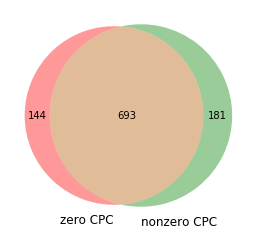

In [12]:
from matplotlib_venn import venn2
fullyzeroCPCkeywords = set(fullyzeroCPCrows.Keyword.unique())
nonzeroCPCkeywords = set(data[data.CPC!=0].Keyword.unique())
venn2([fullyzeroCPCkeywords, nonzeroCPCkeywords], ['zero CPC', 'nonzero CPC'])

Here we isolated the unique keywords of the rows for which CPC != 0 (named `nonzeroCPCkeywords`) and took a Venn diagram with the set of unique keywords contained in `fullyzeroCPCrows`. The intersection contains 693 words, and there are 1018 total unique keywords in the dataset.

In summary, only 14% of the unique keywords will be thrown out if we discard all rows with zeroes for six numeric features. This still looks like a significant number of unique keywords our ML model will not be trained on. This is however an okay price to pay because the alternative is including the 693 keywords for which there are both meaningful data points *and* meaningless data points (six features zeroed out) - clearly something that will confuse the model. Also, since 42% of the data will have zero values for six numeric features, they will heavily pull the predicted values to the left.

Thus we conclude: **for a more stable result we will get rid of the rows with zero CPC.** However, also note that there are rows where CPC is zero but either AveragePosition or Impressions is nonzero. We will keep these rows because they might represent keywords that are very uninteresting, because people saw them but did not click at all.

In [13]:
data = data[(data.CPC != 0.0) | (data.AveragePosition != 0.0) | (data.Impressions != 0.0)]

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203643 entries, 1 to 356039
Data columns (total 9 columns):
Date               203643 non-null int64
Market             203643 non-null object
Keyword            203643 non-null object
CPC                203643 non-null float64
Clicks             203643 non-null float64
CTR                203643 non-null float64
Impressions        203643 non-null float64
Cost               203643 non-null float64
AveragePosition    203643 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 15.5+ MB


We are now left with 203,643 data points.

## Further data exploration and data preparation

This is the distribution of Market values:

In [15]:
data.Market.value_counts(normalize=True)

US-Market    0.682729
UK-Market    0.317271
Name: Market, dtype: float64

This is the distribution of date values per year:

In [16]:
data['Year'] = data.Date.astype('str').apply(lambda x: x[:4]).astype('int')

In [17]:
data.Year.value_counts(normalize=True)

2012    0.794351
2013    0.205649
Name: Year, dtype: float64

This is the distribution of values for different months in 2012. The dataset starts from May until December 2012.

In [18]:
data['Month'] = data.Date.astype('str').apply(lambda x: x[4:6]).astype('int')

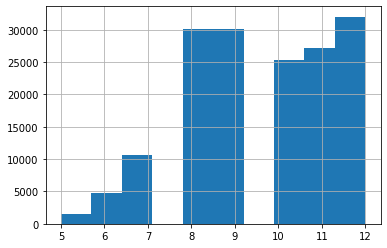

In [19]:
data.Month[data.Year == 2012].hist()

The graph below is for 2013. Note that only January and February are in the dataset

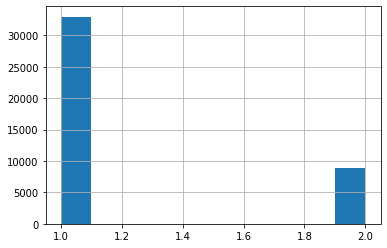

In [20]:
data.Month[data.Year == 2013].hist()

Let's derive one more categorical feature from the date - the season:

In [21]:
def get_season(month):
    if month >= 3 and month < 6:
        return 1 # Spring
    elif month >= 6 and month < 9:
        return 2 # Summer
    elif month >= 9 and month < 11:
        return 3 # Fall
    else: 
        return 4 # Winter

data['Season'] = data.Month.apply(get_season)

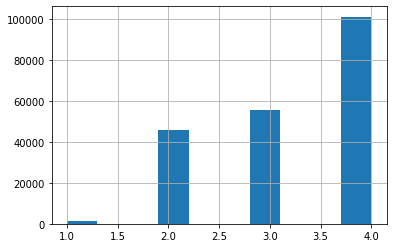

In [22]:
data.Season.hist()

**Most of our data is in Winter.** If we want good performance from our model, we should collect data equally from every month because the time of the year affects which keyword searches are popular

In [23]:
data.describe()

,Date,CPC,Clicks,CTR,Impressions,Cost,AveragePosition,Year,Month,Season
count,2.036430e+05,203643.000000,203643.000000,203643.000000,2.036430e+05,203643.000000,203643.000000,203643.000000,203643.000000,203643.000000
mean,2.012286e+07,24.734849,381.375764,2.823360,1.689422e+04,3289.980712,1.058026,2012.205649,7.908492,3.257613
std,3.703302e+03,47.180110,2248.428930,1.947706,9.337315e+04,13062.608075,0.495277,0.404176,3.751943,0.827082
min,2.012052e+07,0.000000,0.000000,0.000000,1.200000e+01,0.000000,1.000000,2012.000000,1.000000,1.000000
25%,2.012090e+07,2.500000,5.380000,1.300000,2.620000e+02,31.340000,1.000000,2012.000000,7.000000,3.000000
50%,2.012103e+07,9.120000,23.980000,2.500000,1.051000e+03,233.030000,1.000000,2012.000000,9.000000,3.000000
75%,2.012122e+07,25.660000,114.625000,3.900000,4.721000e+03,1371.900000,1.000000,2012.000000,11.000000,4.000000
max,2.013021e+07,632.730000,89233.580000,23.700000,3.666042e+06,285716.050000,12.000000,2013.000000,12.000000,4.000000


Important observations:
- For AveragePosition, the 75th percentile is 1.0, and actually 95% of the data have value 1.0 (see next cell)
- The maximum value of CPC is 632 while the 50th percentile is 9.12 and the standard deviation is 24.74. Applying logarithm of base 2 will help normalize this feature.
- The maximum value of Clicks is four orders of magnitude higher than its 50th percentile, meanwhile its mean is 381 but its standard deviation is 2248. A stronger transformation is needed. We will use logarithm with base 10.
- We can also observe a similar situation with Impressions and Cost, so we will also use logarithm with base 10.

In [24]:
data.AveragePosition.value_counts(normalize=True).head()

1.0    0.953743
1.1    0.015763
1.2    0.005485
1.3    0.003108
1.5    0.001969
Name: AveragePosition, dtype: float64

In [25]:
data.CPC = np.log2(data.CPC.replace(0,0.0001))
data.Clicks = np.log10(data.Clicks.replace(0,0.001))
data.Impressions = np.log10(data.Impressions.replace(0,0.0001))
data.Cost = np.log10(data.Cost.replace(0,0.001))

We now plot histograms of the four transformed features. We can see that indeed we have succeeded in normalizing the values of the four numeric features

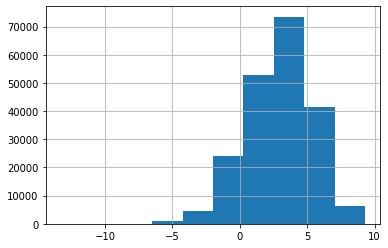

In [26]:
data.CPC.hist()

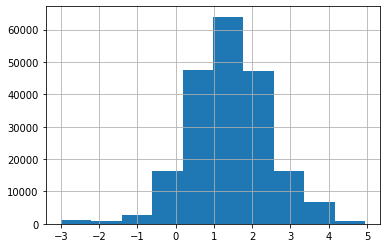

In [27]:
data.Clicks.hist()

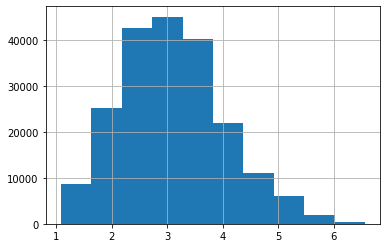

In [28]:
data.Impressions.hist()

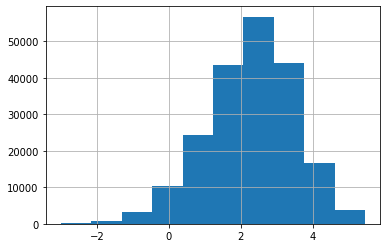

In [29]:
data.Cost.hist()

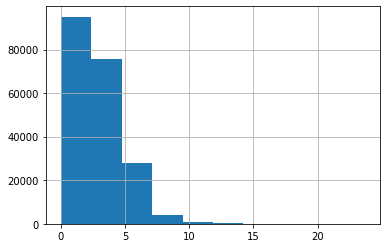

In [30]:
data.CTR.hist()

We apply a few more data transformations in preparation for machine learning tasks. First, the Market feature has to be converted into numerical. Also the keywords must be made into lowercase to improve results when applying NLP techniques.

In [31]:
data['Keyword'] = data.Keyword.apply(lambda x: x.lower())
data['Market'] = data.Market.map({'US-Market':1, 'UK-Market':0})

In [32]:
data.head()

,Date,Market,Keyword,CPC,Clicks,CTR,Impressions,Cost,AveragePosition,Year,Month,Season
1,20120524,1,agile management software,0.263034,1.326745,8.2,2.414973,1.405688,1.0,2012,5,1
9,20120524,1,android app developers,-0.599462,1.367542,8.6,2.431364,1.184975,1.0,2012,5,1
13,20120524,1,android application developer,0.028569,1.671358,8.6,2.737193,1.679155,1.0,2012,5,1
14,20120524,1,android app developer,0.378512,2.168674,6.0,3.392521,2.283279,1.0,2012,5,1
17,20120524,1,mobile applications developers,-0.810966,1.336260,8.3,2.414973,1.090258,1.0,2012,5,1


We save the cleaned dataset to a csv file.

In [34]:
data.to_csv('cleaned_data.csv', index_label=False)

We must take note of all the data transformations we applied. Here is a table summary:

| feature name        |    original format/type        |  transformation applied           |
|:--------------------|:--------------------------|:----------------------------------|
| Date                |    int: YYYYMMDD          |  3 new int features: Year, Month, Season  |
| Market              | str: 'US-Market' or 'UK-Market' |   int: 1 or 0 (respectively)  |
| Keyword             |    str                     |      take lowercase              |
| CPC                 |   float                   |      apply np.log2                |
| Clicks              |   float                   |      apply np.log10               |
| CTR                 |   float (0 to 100)        |      (none)                       |
| Impressions         |   float                   |      apply np.log10               |
| Cost                |   float                   |      apply np.log10               |
| AveragePosition     |   float  (0 to 12)        |      (none)                       |

Also note that we discarded rows with null values, and also rows with zeroes for CPC, CTR, Clicks, Impressions, Cost and AP all simultaneously.

All of these data cleaning and transformation actions are replicated in `prepare_data.py`